##An Implementation of General Fused Lasso
Based on - Graph -Structured Multi-task Regression and Efficient Optimization Method for General Fused Lasso;
Authors 	- Xi Chen, Seyoung Kim, Qihang Lin, Jaime G. Carbonell, Eric P. Xing\\
Source 		- [v1] Thu, 20 May 2010 on arXiv:1005.3579 https://arxiv.org/abs/1005.3579
By: Andrew Murza, Nitin Mishra, Abhilash Chaudhary

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import time
import pylab
from sklearn.linear_model import MultiTaskLasso, Lasso
from sklearn.model_selection import train_test_split
rng = np.random.RandomState(42)
%matplotlib inline

##GFLasso with Proximal Gradiet function
Model design for general fused lasso along with proximal gradient method

In [4]:
class GraphFusedLasso():
    """
    Graph-Guided Fused Lasso
    """
    def __init__(
        self, G, theta_val=0, X_b=0, lr=0, n_iter=0,max_iterations=50, lambda_val=1.0, gamma_val=1.0, epsilon=1.0, tol=10**-6,
        no_bias=False, verbose=False, grad_func=1,
    ):
        self.G = G
        self.max_iterations = max_iterations
        self.lambda_val = lambda_val
        self.gamma_val = gamma_val
        self.epsilon = epsilon  
        self.tol = tol
        self.no_bias = no_bias
        self.verbose = verbose
        self.grad_func='proximal'
        self.theta_val = theta_val

    
    def fit(self, X, y):
        #adding bias for y_pred
#        print(grad_func)
        if grad_func == 1:
          if not self.no_bias:
              X = self.bias_padding(X)
        N, J = X.shape
        tasks = y.shape[1] #K
        edges = np.nonzero(self.G)[0].shape[0] #E

        # Initialize vertex-edge incident matrix H with KxE 
        H = np.zeros((tasks, edges)) 
        #Fill H as per Sec 4.1 definition
        for k in range(tasks):
            for e, (m, l) in enumerate(zip(*np.nonzero(self.G ))):
                if k == m:
                    H[k, e] = np.abs(self.G[m, l])
                elif k == l:
                    H[k, e] = -np.sign(self.G[m, l]) * np.abs(self.G[m, l])
                    
        I = np.identity(tasks)
        # lasso and graph-guided fusion penalty functions as ||BC||_1, with C = (λI, γH)
        C = np.concatenate((self.lambda_val * I, self.gamma_val * H), axis=1)
        #d(A) ≡1/2*||A||^2_F; D = 1/2*J(K+E) Sec 4.2
        D = 0.5 * J * (tasks + edges)
        #||Γ||_U, mapping from JxK to Jx(K+|E|)
        d_k = np.sum(self.G**2, axis=1)
        #mu defined to achieve best convergance rate
        mu = self.epsilon / (2. * D)
        #eigenvector X^TX 
        eigen_value, _ = np.linalg.eig(np.dot(X.T, X))
        #Upper bounded Lipschitz constant Eq 12 L_U = λmax(XTX) + (λ^2 + 2γ^2 maxk∈V d_k)/µ
        L_u = np.max(eigen_value) + (self.lambda_val**2 + 2 * self.gamma_val**2 * np.max(d_k)) / mu

        # Proximal Gradient Function, Algorithm 1
        W_prev = np.zeros((J, tasks))
        B = np.ones((J, tasks))
        Z_prev = 0.
        B_prev = 0.
        coefdiff_history = []
        loss_history = []
        if grad_func == 1:
          B, coefdiff_history, loss_history = self.proximal_gradient(W_prev, B_prev, B, X, y, C, mu, L_u, Z_prev, self.max_iterations, loss_history, coefdiff_history)
        #Stochastic Gradient Method added only for the Computation Comparison purpose.
        #This method cannot be used for generating useful output
        elif grad_func == 2:
          self.theta,self.cost_history = stochastic_grad_desc(X_b,y,theta,lr,n_iter)
        #Stochastic Gradient Method added only for the Computation Comparison purpose.
        #This method cannot be used for generating useful output
        elif grad_func == 3:
          w_init = np.random.randn(X.shape[1])
          w,b = stochastic_subgrad(X,y,w_init,b = 10,tradeoff=1, itr=n_iter)
        else:
          print("Define Gradient Function to use")


        self.coef_ = B.T[:, :-1] if not self.no_bias else B.T
        self.intercept_ = B.T[:, -1] if not self.no_bias else np.zeros(tasks)
        self.coefdiff_history_ = coefdiff_history
        self.loss_history_ = loss_history
        return self

    def gflasso_prediction(self, X):
        #model definition Eq 1
        y_pred = np.dot(X, self.coef_.T) + self.intercept_
        return y_pred

    def bias_padding(self, X):
        b = np.ones((X.shape[0], 1), dtype=X.dtype)
        return np.concatenate((X, b), axis=1)
    
    #Eq 14 as graph fusion penalty
    def graph_fusion_penalty(self, X, y, B):
        #vector l2-norm
        loss = 0.5 * np.sum((y - np.dot(X, B))**2)
        loss += self.lambda_val * np.linalg.norm(B, ord=1)
        for e, (m, l) in enumerate(zip(*np.nonzero(self.G))):
            r = self.G[m, l]
            s = np.sign(r)
            loss += self.gamma_val * np.abs(r) * np.sum(np.abs(B[:, m] - s * B[:, l]))
        return loss
    
    def proximal_gradient(self, W_prev, B_prev, B, X, y, C, mu, L_u, Z_prev, itr, loss_history, coefdiff_history):
        for itr in range(self.max_iterations):
        #derivaative of Optimal solution A*
        #lemma 1
            S_A = shrinkage_operator(np.dot(W_prev, C) / mu)
            #Eq 11∇f(B) = X^T(XB − Y) + A∗C^TT
            grad_f_b = np.dot(X.T, (np.dot(X, W_prev) - y)) + np.dot(S_A, C.T)
    
            # Gradient descent step
            B = threshold_offset(W_prev - grad_f_b / L_u, self.lambda_val / L_u)
                
            # Step 3 
            Z = Z_prev - 0.5 * (itr + 1) * grad_f_b / L_u 
    
            # Step 4
            W_prev = ((itr + 1) / (itr + 3)) * B + (2 / (itr + 3)) * Z 
    
            # Check termination condition
            loss = self.graph_fusion_penalty(X, y, B)
            # fusion penalty defined on inputs ordered in time as a chain
            #i.e., special case of graph_fusion_penalty
            special_case_penalty = np.mean(np.abs(B - B_prev)) if itr > 0 else np.inf
            loss_history.append(loss)
            coefdiff_history.append(special_case_penalty)
            
            if self.verbose:
                print("Iter {0}: Fusion Penalty = {1:e}, Loss = {2:e}".format(
                    itr + 1, special_case_penalty, loss))
            if special_case_penalty <= self.tol:
                #print(itr)
                break
            B_prev = B
            Z_prev = Z
            
        return  B, coefdiff_history, loss_history

In [5]:
def shrinkage_operator(array):
    #For x ∈ R, S(x) = x if −1 < x < 1,
    #S(x) = 1 if x ≥ 1, and S(x) = −1 if x ≤ −1
    array = np.where(array >= 1., 1., array)  # if x >= 1
    array = np.where(array <= -1., -1., array)  # if x <= -1
    return array


In [6]:
def threshold_offset(array, lambda_val):
    array_new = np.zeros_like(array)
    array_new[np.where(array > lambda_val)] = array[np.where(array > lambda_val)] - lambda_val
    array_new[np.where(array < -lambda_val)] = array[np.where(array < -lambda_val)] + lambda_val
    return array_new

##Stochastic Gradient Descent
For comparison purpose only

In [7]:
def fn_cost(theta,X,y):
        predictions = X.dot(theta)
        cost = (1/2*len(y)) * np.sum(np.square(predictions-y))
        return cost

In [8]:
def stochastic_grad_desc(X,y,theta,learning_rate=0.01,itr=10):
        cost_history = np.zeros(itr)    
        for it in range(itr):
            cost =0.0
            for i in range(len(y)):
                rand_idx = np.random.randint(0,len(y))
                X_i = X[rand_idx,:].reshape(1,X.shape[1])
                y_i = y[rand_idx,:].reshape(1,y.shape[1])
                pred = np.dot(X_i,theta)

                theta = theta -(1/len(y))*learning_rate*( X_i.T.dot((pred - y_i)))
                cost += fn_cost(theta,X_i,y_i)
            cost_history[it]  = cost
        
        return theta, cost_history

##Stochastic Sub-Gradient
For comparison purpose only

In [ ]:
def add_subgrad(w, subgradient_w):
    """
    total_w = w + C *  ∑ (-y*x)
    
    """
    return w + subgradient_w

In [ ]:
def calc_subgradient(x, y, w, b, tradeoff):
   
    subgrad_w = 0
    subgrad_b = 0
    
    # sum over all subgradients of hinge loss for a given samples x,y
    for xi, yi in zip(x,y):
        fxi = np.dot(w.T, xi) + b

        threshold_val = yi * fxi

        if threshold_val < 1:
            subgrad_w += - yi*xi
            subgrad_b += -1 * yi
        else:
            subgrad_w += 0
            subgrad_b += 0
    
    # multiply by C after summation of all subgradients for a given samples of x,y
    subgrad_w = tradeoff * subgrad_w
    subgrad_b = tradeoff * subgrad_b
    return (add_subgrad(w, subgrad_w), subgrad_b)

In [ ]:
def stochastic_subgrad(X, y, w, b, tradeoff, itr=50):
    
    for t in range(1, itr+1):
        learning_rate = 1/t        
        for i in range(0, y.shape[1]):
          #print(y[:,i])
          sub_grads = calc_subgradient(X,y[:,i], w, b, tradeoff)
        
        # update weights
          w = w - learning_rate * sub_grads[0]
        
        # update bias
          b = b - learning_rate * sub_grads[1]
    return (w,b)

##Initialization
Initializing Graph G, X, y, number of samples N, number of features J and number of tasks K

In [ ]:

N, J, K = 1000, 30, 40 # N = number of samples, J = features, K = tasks
n_relevant_features = 5
coef = np.zeros((K, J))
times = np.linspace(0, 2 * np.pi, K // 2)
for k in range(n_relevant_features):
    coef[:K // 2, k] = np.sin((1. + rng.randn(1)) * times + 3 * rng.randn(1))
    coef[K // 2:, k] = coef[:K // 2, k]

X = rng.randn(N, J)
#X=np.random.normal(0, 1, size=(N, J))
y = np.dot(X, coef.T) + rng.randn(N, K)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.7,
                                                    random_state=42)

G = np.identity(K)

for j in range(K // 2):
    G[j, K // 2 + j] = G[K // 2 + j, j] = 1.0


##GFLasso Model with Proximal Gradient Method
Also computes false positive rate and true positive rate for each relevant feature

In [10]:
grad_func=1
gflasso_model = GraphFusedLasso(G, verbose=True, max_iterations=1000, lambda_val=2., epsilon=1.).fit(X_train, y_train)
gflasso_coefficients_ = gflasso_model.coef_

rho = 0.5
gflasso_coefficients = np.zeros_like(gflasso_coefficients_)
gflasso_coefficients[gflasso_coefficients_ < rho] = 0

from sklearn.metrics import roc_auc_score, roc_curve, auc

y_pred=gflasso_model.gflasso_prediction(X_test)
y_test_classes = np.zeros_like(y_pred)
cutoff = 0.1   
y_test_classes[y_test > cutoff] = 1
fpr_gfl = dict()
tpr_gfl = dict()

for i in range(n_relevant_features):
    fpr_gfl[i], tpr_gfl[i], _ = roc_curve(y_test_classes[:, i], y_pred[:,i])
    auc = roc_auc_score(y_test_classes[:, i], y_pred[:,i] )
    print("Area under ROC curve for relevant feature at index {0}: {1:e}".format(i,auc))

894
0.85511066003143
0.920350493959974
0.907702915681639
0.9092051985370951
0.9242883150598818


##Lasso Model
Also computes false positive rate and true positive rate for each relevant feature

In [11]:
lasso_model = Lasso(alpha=0.5).fit(X, y)
lasso_coefficients = lasso_model.coef_

fpr_lasso = dict()
tpr_lasso = dict()

y_pred_lasso = lasso_model.predict(X_test)[:,1]

for i in range(n_relevant_features):
    fpr_lasso[i], tpr_lasso[i], _ = roc_curve(y_test_classes[:, i], y_pred_lasso[:])

##MultiTaskLasso Model
Also computes false positive rate and true positive rate for each relevant feature

In [12]:
multi_task_model = MultiTaskLasso(alpha=1.).fit(X, y)
multi_task_lasso_coefficients = multi_task_model.coef_
fpr_l1l2 = dict()
tpr_l1l2 = dict()

y_pred_l1l2 = multi_task_model.predict(X_test)[:,1]

for i in range(n_relevant_features):
    fpr_l1l2[i], tpr_l1l2[i], _ = roc_curve(y_test_classes[:, i], y_pred_l1l2[:])


##ROC Curve
ROC Curve for GFLasso, Lasso and MultiTaskLasso Models

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

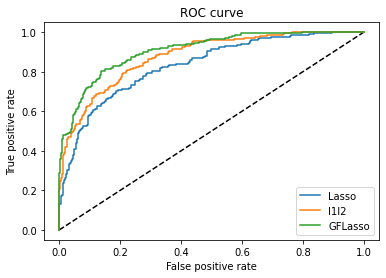

In [15]:

from matplotlib import pyplot as plt
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_lasso[2], tpr_lasso[2], label='Lasso')
plt.plot(fpr_l1l2[2], tpr_l1l2[2], label='l1l2')
plt.plot(fpr_gfl[2], tpr_gfl[2], label='GFLasso')

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
from google.colab import files
plt.savefig("ROC_idx_2.png")
files.download("ROC_idx_2.png") 
plt.show()


##Regression Coefficients for all models

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

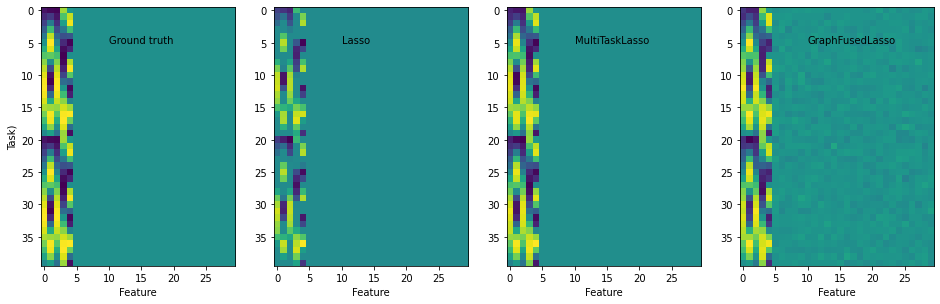

In [52]:
fig = plt.figure(figsize=(16, 5))
plt.subplot(1, 4, 1)
plt.imshow(coef)
plt.xlabel('Feature')
plt.ylabel('Task)')
plt.text(10, 5, 'Ground truth')
plt.subplot(1, 4, 2)
plt.imshow(lasso_coefficients)
plt.xlabel('Feature')
plt.text(10, 5, 'Lasso')
plt.subplot(1, 4, 3)
plt.imshow(multi_task_lasso_coefficients)
plt.xlabel('Feature')
plt.text(10, 5, 'MultiTaskLasso')
plt.subplot(1, 4, 4)
plt.imshow(gflasso_coefficients_)
plt.xlabel('Feature')
plt.text(10, 5, 'GraphFusedLasso')
from google.colab import files
plt.savefig("Coeffs.png")
files.download("Coeffs.png") 
plt.show()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

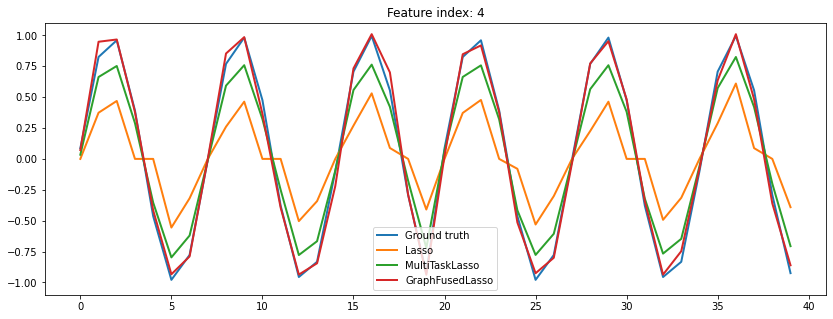

In [50]:
fig = plt.figure(figsize=(14, 5))
lw = 2
feature_to_plot = 4
plt.plot(coef[:, feature_to_plot], linewidth=lw,
         label='Ground truth')
plt.plot(lasso_coefficients[:, feature_to_plot], linewidth=lw,
         label='Lasso')
plt.plot(multi_task_lasso_coefficients[:, feature_to_plot], linewidth=lw,
         label='MultiTaskLasso')
plt.plot(gflasso_coefficients_[:, feature_to_plot], linewidth=lw,
         label='GraphFusedLasso')
plt.legend(loc='lower center')
plt.axis('tight')
plt.title("Feature index: {}".format(feature_to_plot))
plt.ylim([-1.1, 1.1])

from google.colab import files
plt.savefig("Feature.png")
files.download("Feature.png") 
plt.show()

##Heatmap of relevant feature

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

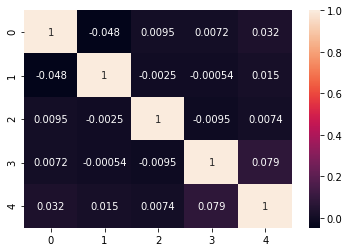

In [51]:
import seaborn as sns

import pandas as pd
X=pd.DataFrame(X)
# taking all rows but only 5 columns
df_small = X.iloc[:,:n_relevant_features]

correlation_mat = df_small.corr()

sns.heatmap(correlation_mat, annot = True)
from google.colab import files
plt.savefig("Heatmap.png")
files.download("Heatmap.png") 
plt.show()

##Evaluation in terms of J
varying value of J from 1000 to 10000 with step size of 1000

In [ ]:
import time

comp_time_J_prox = []
comp_time_J_sgd = []
comp_time_J_subg = []
for J in range(1000,10000,1000):

  N, K = 1000, 40 # N = number of samples, J = features, K = tasks
  n_relevant_features = 5
  coef = np.zeros((K, J))
  c = np.linspace(0, 2 * np.pi, K // 2)
  for k in range(n_relevant_features):
      coef[:K // 2, k] = np.sin((1. + rng.randn(1)) * c + 2 * rng.randn(1))
      coef[K // 2:, k] = coef[:K // 2, k]

  #X = rng.randn(N, J)
  X=np.random.normal(0, 1, size=(N, J))
  y = np.dot(X, coef.T) + rng.randn(N, K)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.7,
                                                      random_state=42)
  
  G = np.identity(K)
  grad_func=1
  for j in range(K // 2):
      G[j, K // 2 + j] = G[K // 2 + j, j] = 1.0

  
  print("J = {0} for Proximal Gradient Function".format(J))
  start_time = time.time()
  gflasso_model = GraphFusedLasso(G, verbose=True, max_iterations=1000, lambda_val=2., epsilon=1.,grad_func=1).fit(X, y)
  end_time = time.time()
  comp_time_J_prox.append(end_time - start_time)
  grad_func=2
  
  print("J = {0} for Stochastic Gradient Function".format(J))
  start_time = time.time()
  lr =0.5
  n_iter = 50
  theta = np.random.randn(J+1,1)
  X_b = np.c_[np.ones((len(X),1)),X]
  gflasso_model = GraphFusedLasso(G, theta,X_b,lr,n_iter=n_iter, verbose=True, max_iterations=1000, lambda_val=2., epsilon=1,grad_func=2).fit(X, y)
  end_time = time.time()
  comp_time_J_sgd.append(end_time - start_time)

  print("J = {0} for Stochastic Sub-Gradient Function".format(J))
  start_time = time.time()
  gflasso_model = GraphFusedLasso(G, verbose=True,grad_func=3, n_iter=50).fit(X, y)
  end_time = time.time()
  comp_time_J_subg.append(end_time - start_time)
print(comp_time_J_prox)
print(comp_time_J_subg)

J = 1000 for Proximal Gradient Function
J = 1000 for Stochastic Gradient Function
J = 1000 for Stochastic Sub-Gradient Function
J = 2000 for Proximal Gradient Function
J = 2000 for Stochastic Gradient Function
J = 2000 for Stochastic Sub-Gradient Function
J = 3000 for Proximal Gradient Function
J = 3000 for Stochastic Gradient Function
J = 3000 for Stochastic Sub-Gradient Function
J = 4000 for Proximal Gradient Function
J = 4000 for Stochastic Gradient Function
J = 4000 for Stochastic Sub-Gradient Function
J = 5000 for Proximal Gradient Function
J = 5000 for Stochastic Gradient Function
J = 5000 for Stochastic Sub-Gradient Function
J = 6000 for Proximal Gradient Function
J = 6000 for Stochastic Gradient Function
J = 6000 for Stochastic Sub-Gradient Function
J = 7000 for Proximal Gradient Function
J = 7000 for Stochastic Gradient Function
J = 7000 for Stochastic Sub-Gradient Function
J = 8000 for Proximal Gradient Function
J = 8000 for Stochastic Gradient Function
J = 8000 for Stochasti

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

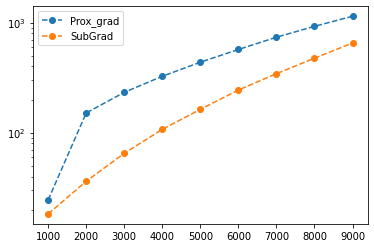

In [ ]:
# Random X
comp_time_J_prox=[24.543862342834473, 151.35878896713257, 232.7870545387268, 325.7700753211975, 437.12480187416077, 570.6482968330383, 737.5211029052734, 926.0571410655975, 1143.4936137199402]
comp_time_J_subg=[18.299408435821533, 36.21959400177002, 64.98038983345032, 107.28624105453491, 163.075453042984, 244.21183276176453, 343.64225935935974, 475.861576795578, 653.4304647445679]

#Normal Distribution X
#comp_time_J_prox = [27.635534524917603, 156.98772144317627, 237.92661786079407, 338.9670236110687, 461.8965120315552, 603.6267650127411, 767.9135549068451, 1009.3803911209106, 1247.4318089485168]
#comp_time_J_subg = [20.421093702316284, 38.149115324020386, 68.76089596748352, 112.44459652900696, 175.34537506103516, 265.1817409992218, 387.21791982650757, 535.1038284301758, 716.0683045387268]

a = [pow(10, i) for i in range(10)]
fig = plt.figure()

J_new=[]
for i in range(1000,10000,1000):
  J_new.append(i)

plt.plot(J_new, comp_time_J_prox, label='Prox_grad', linestyle='--', marker='o')
plt.plot(J_new, comp_time_J_subg, label='SubGrad', linestyle='--', marker='o')
plt.yscale("log")
plt.legend(loc='best')
from google.colab import files
plt.savefig("Evaluation_Varying_J_Random_X.png")
files.download("Evaluation_Varying_J_Random_X.png") 
plt.show()

##Evaluation in terms of N
varying value of N from 500 to 10000 with step size of 1000

In [ ]:
comp_time_N_prox = []
comp_time_N_sgd = []
comp_time_N_subg = []
for N in range(500,10000,500):

  J, K = 30, 40 # N = number of samples, J = features, K = tasks
  n_relevant_features = 5
  coef = np.zeros((K, J))
  c = np.linspace(0, 2 * np.pi, K // 2)
  for k in range(n_relevant_features):
      coef[:K // 2, k] = np.sin((1. + rng.randn(1)) * c + 2 * rng.randn(1))
      coef[K // 2:, k] = coef[:K // 2, k]

  #X = rng.randn(N, J)
  X=np.random.normal(0, 1, size=(N, J))
  y = np.dot(X, coef.T) + rng.randn(N, K)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.7,
                                                      random_state=42)
  
  G = np.identity(K)
  grad_func=1
  for j in range(K // 2):
      G[j, K // 2 + j] = G[K // 2 + j, j] = 1.0
  start_time = time.time()
  print("N = {0} for Proximal Gradient Function".format(N))
  gflasso_model = GraphFusedLasso(G, verbose=True, max_iterations=1000, lambda_val=2., epsilon=1.,grad_func=1).fit(X, y)
  end_time = time.time()
  comp_time_N_prox.append(end_time - start_time)
  grad_func=2
  
  print("N = {0} for Stochastic Gradient Function".format(N))
  start_time = time.time()
  lr =0.5
  n_iter = 50
  theta = np.random.randn(J+1,1)
  X_b = np.c_[np.ones((len(X),1)),X]
  gflasso_model = GraphFusedLasso(G, theta,X_b,lr,n_iter=n_iter, verbose=True, max_iterations=1000, lambda_val=2., epsilon=1,grad_func=2).fit(X, y)
  end_time = time.time()
  comp_time_N_sgd.append(end_time - start_time)

  print("N = {0} for Stochastic Sub-Gradient Function".format(N))
  start_time = time.time()
  gflasso_model = GraphFusedLasso(G, verbose=True,grad_func=3, n_iter=50).fit(X, y)
  end_time = time.time()
  comp_time_N_subg.append(end_time - start_time)
print(comp_time_N_prox)
print(comp_time_N_subg)

N = 500 for Proximal Gradient Function
N = 500 for Stochastic Gradient Function
N = 500 for Stochastic Sub-Gradient Function
N = 1000 for Proximal Gradient Function
N = 1000 for Stochastic Gradient Function
N = 1000 for Stochastic Sub-Gradient Function
N = 1500 for Proximal Gradient Function
N = 1500 for Stochastic Gradient Function
N = 1500 for Stochastic Sub-Gradient Function
N = 2000 for Proximal Gradient Function
N = 2000 for Stochastic Gradient Function
N = 2000 for Stochastic Sub-Gradient Function
N = 2500 for Proximal Gradient Function
N = 2500 for Stochastic Gradient Function
N = 2500 for Stochastic Sub-Gradient Function
N = 3000 for Proximal Gradient Function
N = 3000 for Stochastic Gradient Function
N = 3000 for Stochastic Sub-Gradient Function
N = 3500 for Proximal Gradient Function
N = 3500 for Stochastic Gradient Function
N = 3500 for Stochastic Sub-Gradient Function
N = 4000 for Proximal Gradient Function
N = 4000 for Stochastic Gradient Function
N = 4000 for Stochastic S

[1.7502226829528809, 1.0987131595611572, 0.8918313980102539, 0.8624117374420166, 0.8024282455444336, 0.6992778778076172, 0.6947231292724609, 0.7428948879241943, 0.6163134574890137, 0.6007742881774902, 0.6111116409301758, 0.602060079574585, 0.5894467830657959, 0.5747578144073486, 0.5769977569580078, 0.5957958698272705, 0.6129364967346191, 0.6109001636505127, 0.6175305843353271]
[0.706697940826416, 1.4935050010681152, 2.1821913719177246, 2.6953771114349365, 3.381666421890259, 4.15513801574707, 5.108561277389526, 5.522367238998413, 6.096566200256348, 6.858453989028931, 7.681184530258179, 8.403875350952148, 8.831019639968872, 9.525176525115967, 10.188826560974121, 11.004908084869385, 11.664239406585693, 12.511788606643677, 13.351653099060059]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

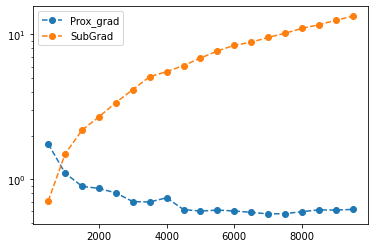

In [ ]:

# Random X
#comp_time_N_prox = [1.6524100303649902, 1.0764613151550293, 0.8702692985534668, 0.7575669288635254, 0.7244038581848145, 0.708141565322876, 0.6475667953491211, 0.6390447616577148, 0.6226475238800049, 0.6034164428710938, 0.6401464939117432, 0.6154055595397949, 0.6249487400054932, 0.5878493785858154, 0.5842859745025635, 0.6210455894470215, 0.6097066402435303, 0.5902907848358154, 0.5882308483123779]
#comp_time_N_subg = [0.6896660327911377, 1.450862169265747, 2.0305209159851074, 2.7442500591278076, 3.486647129058838, 4.114997863769531, 4.959404945373535, 5.4457550048828125, 6.383319139480591, 6.859850168228149, 7.523995399475098, 8.253390073776245, 9.128736019134521, 9.697450160980225, 10.434390544891357, 11.100789308547974, 11.551125288009644, 12.4006028175354, 13.446029901504517]

#Normal Distribution X
comp_time_N_prox = [1.7502226829528809, 1.0987131595611572, 0.8918313980102539, 0.8624117374420166, 0.8024282455444336, 0.6992778778076172, 0.6947231292724609, 0.7428948879241943, 0.6163134574890137, 0.6007742881774902, 0.6111116409301758, 0.602060079574585, 0.5894467830657959, 0.5747578144073486, 0.5769977569580078, 0.5957958698272705, 0.6129364967346191, 0.6109001636505127, 0.6175305843353271]
comp_time_N_subg = [0.706697940826416, 1.4935050010681152, 2.1821913719177246, 2.6953771114349365, 3.381666421890259, 4.15513801574707, 5.108561277389526, 5.522367238998413, 6.096566200256348, 6.858453989028931, 7.681184530258179, 8.403875350952148, 8.831019639968872, 9.525176525115967, 10.188826560974121, 11.004908084869385, 11.664239406585693, 12.511788606643677, 13.351653099060059]

a = [pow(10, i) for i in range(10)]
fig = plt.figure()

N_new=[]
for i in range(500,10000,500):
  N_new.append(i)

plt.plot(N_new, comp_time_N_prox, label='Prox_grad', linestyle='--', marker='o')
plt.plot(N_new, comp_time_N_subg, label='SubGrad', linestyle='--', marker='o')

plt.yscale("log")
plt.legend(loc='best')
from google.colab import files
plt.savefig("Evaluation_Varying_N_Normal_X.png")
files.download("Evaluation_Varying_N_Normal_X.png") 
plt.show()

##Evaluation in terms of K
varying value of K from 1000 to 8000 with step size of 1000

In [ ]:
comp_time_K_prox = []
comp_time_K_sgd = []
comp_time_K_subg = []
for K in range(1000,8000,1000):

  N, J = 1000, 30 # N = number of samples, J = features, K = tasks
  n_relevant_features = 5
  coef = np.zeros((K, J))
  c = np.linspace(0, 2 * np.pi, K // 2)
  for k in range(n_relevant_features):
      coef[:K // 2, k] = np.sin((1. + rng.randn(1)) * c + 2 * rng.randn(1))
      coef[K // 2:, k] = coef[:K // 2, k]

  X = rng.randn(N, J)
  #X=np.random.normal(0, 1, size=(N, J))
  y = np.dot(X, coef.T) + rng.randn(N, K)
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.7,
                                                      random_state=42)
  
  G = np.identity(K)
  grad_func=1
  for j in range(K // 2):
      G[j, K // 2 + j] = G[K // 2 + j, j] = 1.0
  start_time = time.time()
  print("K = {0} for Proximal Gradient Function".format(K))
  gflasso_model = GraphFusedLasso(G, verbose=True, max_iterations=1000, lambda_val=2., epsilon=1.,grad_func=1).fit(X, y)
  end_time = time.time()
  comp_time_K_prox.append(end_time - start_time)
  grad_func=2
  
  print("K = {0} for Stochastic Gradient Function".format(K))
  start_time = time.time()
  lr =0.5
  n_iter = 50
  theta = np.random.randn(J+1,1)
  X_b = np.c_[np.ones((len(X),1)),X]
  gflasso_model = GraphFusedLasso(G, theta,X_b,lr,n_iter=n_iter, verbose=True, max_iterations=1000, lambda_val=2., epsilon=1,grad_func=2).fit(X, y)
  end_time = time.time()
  comp_time_K_sgd.append(end_time - start_time)

  print("K = {0} for Stochastic Sub-Gradient Function".format(K))
  start_time = time.time()
  gflasso_model = GraphFusedLasso(G, verbose=True,grad_func=3, n_iter=50).fit(X, y)
  end_time = time.time()
  comp_time_K_subg.append(end_time - start_time)
print(comp_time_K_prox)
print(comp_time_K_subg)

K = 1000 for Proximal Gradient Function
K = 1000 for Stochastic Gradient Function
K = 1000 for Stochastic Sub-Gradient Function
K = 2000 for Proximal Gradient Function
K = 2000 for Stochastic Gradient Function
K = 2000 for Stochastic Sub-Gradient Function
K = 3000 for Proximal Gradient Function
K = 3000 for Stochastic Gradient Function
K = 3000 for Stochastic Sub-Gradient Function
K = 4000 for Proximal Gradient Function
K = 4000 for Stochastic Gradient Function
K = 4000 for Stochastic Sub-Gradient Function
K = 5000 for Proximal Gradient Function
K = 5000 for Stochastic Gradient Function
K = 5000 for Stochastic Sub-Gradient Function
K = 6000 for Proximal Gradient Function
K = 6000 for Stochastic Gradient Function
K = 6000 for Stochastic Sub-Gradient Function
K = 7000 for Proximal Gradient Function
K = 7000 for Stochastic Gradient Function
K = 7000 for Stochastic Sub-Gradient Function
[121.5137665271759, 352.7910442352295, 724.7827446460724, 1318.319215297699, 2183.0467767715454, 3340.73

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

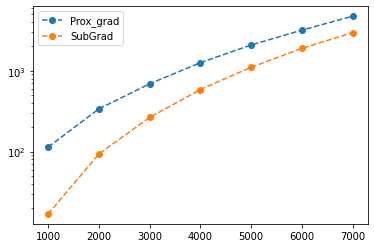

In [ ]:
# Random X
#comp_time_K_prox = [121.5137665271759, 352.7910442352295, 724.7827446460724, 1318.319215297699, 2183.0467767715454, 3340.735093355179, 4900.298081159592]
#comp_time_K_subg = [17.646416425704956, 95.27220606803894, 275.81103587150574, 608.4826486110687, 1161.9301245212555, 1950.5011146068573, 3049.594600915909]

#Normal Distribution X
comp_time_K_prox = [113.9111864566803, 337.96793007850647, 690.1005334854126, 1258.1055722236633, 2082.5863206386566, 3180.7012462615967, 4724.101638555527]
comp_time_K_subg = [16.972026824951172, 93.48991560935974, 264.95730996131897, 585.7650554180145, 1104.0863575935364, 1890.8375437259674, 2961.358941078186]

a = [pow(10, i) for i in range(10)]
fig = plt.figure()

K_new=[]
for i in range(1000,8000,1000):
  K_new.append(i)

plt.plot(K_new, comp_time_K_prox, label='Prox_grad', linestyle='--', marker='o')
plt.plot(K_new, comp_time_K_subg, label='SubGrad', linestyle='--', marker='o')
plt.yscale("log")
plt.legend(loc='best')
from google.colab import files
plt.savefig("Evaluation_Varying_K_Normal_X.png")
files.download("Evaluation_Varying_K_Normal_X.png") 
plt.show()